In [8]:
!pip install -U "triton-windows"

   ---------------------------------------- 0.0/47.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/47.3 MB ? eta -:--:--
    --------------------------------------- 1.0/47.3 MB 4.4 MB/s eta 0:00:11
   - -------------------------------------- 2.4/47.3 MB 5.6 MB/s eta 0:00:08
   --- ------------------------------------ 3.7/47.3 MB 5.7 MB/s eta 0:00:08
   --- ------------------------------------ 4.7/47.3 MB 5.7 MB/s eta 0:00:08
   ----- ---------------------------------- 6.0/47.3 MB 5.7 MB/s eta 0:00:08
   ------ --------------------------------- 7.3/47.3 MB 5.8 MB/s eta 0:00:07
   ------- -------------------------------- 8.4/47.3 MB 5.8 MB/s eta 0:00:07
   -------- ------------------------------- 9.7/47.3 MB 5.9 MB/s eta 0:00:07
   --------- ------------------------------ 11.0/47.3 MB 5.9 MB/s eta 0:00:07
   --------- ------------------------------ 11.5/47.3 MB 6.0 MB/s eta 0:00:06
   ---------- ----------------------------- 12.6/47.3 MB 5.6 MB/s eta 0:00:07
   -------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import torch
import triton
import triton.language as tl

In [11]:
DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [21]:
def vec_add(x, y, z, n):
    z = x + y
    return z

In [22]:
n = 32
x = torch.randn(n)
y = torch.randn(n)
z = torch.zeros(n)
z = vec_add(x,y,z,n)
z

tensor([ 0.2859, -0.4247,  0.5572, -0.0931,  0.8900,  0.7476, -0.5065,  0.6624,
        -1.6066, -2.5160,  1.0366, -1.3004,  0.1525,  0.9704, -2.0986,  0.5227,
         0.9275, -0.0839, -1.7317,  0.8110, -1.2429,  2.3857,  0.2075, -0.5524,
        -0.2148, -1.1153,  1.2841, -1.1523,  0.7844, -0.5546, -1.6595, -2.1710])

In [23]:
%timeit vec_add(x,y,z,n)

1.69 μs ± 35.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [51]:
@triton.jit
def basic_kernel(x, y, z, n, block_size: tl.constexpr, debug_pid, debug_offsets):
    pid = tl.program_id(axis=0)

    block_start = pid * block_size
    offsets = block_start + tl.arange(0, block_size)

    # Store debug info
    tl.store(debug_pid + pid, pid)
    tl.store(debug_offsets + offsets, offsets, mask=offsets < n)

    mask = offsets < n

    x_partial = tl.load(x + offsets, mask=mask)
    y_partial = tl.load(y + offsets, mask=mask)
    z_partial = x_partial + y_partial

    tl.store(z + offsets, z_partial, mask=mask)

In [49]:
def add(x, y):
    z = torch.empty_like(x)

    assert x.device == DEVICE and y.device == DEVICE and z.device == DEVICE

    n = z.numel()


    grid = lambda meta: (triton.cdiv(n, meta['block_size']),)

    print(grid)

    basic_kernel[grid](x, y, z, n, block_size=1024)

    return z

In [53]:
n = 98204
x = torch.randn(n, device='cuda')
y = torch.randn(n, device='cuda')
z = torch.empty_like(x)

block_size = 1024
grid = (triton.cdiv(n, block_size),)
print(grid)
# Create debug tensors
debug_pid = torch.zeros(grid[0], dtype=torch.int32, device='cuda')
debug_offsets = torch.zeros(n, dtype=torch.int32, device='cuda')

basic_kernel[grid](x, y, z, n, block_size, debug_pid, debug_offsets)

print("PIDs:", debug_pid)
print("Offsets (first block):", debug_offsets[:block_size])

(96,)
PIDs: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95], device='cuda:0', dtype=torch.int32)
Offsets (first block): tensor([   0,    1,    2,  ..., 1021, 1022, 1023], device='cuda:0',
       dtype=torch.int32)


In [64]:
@triton.jit
def vec_add(xptr, yptr, zptr, n, block_size:tl.constexpr):

    pid = tl.program_id(axis=0)
    start = pid * block_size
    offsets = start + tl.arange(0, block_size)

    x = tl.load(xptr + offsets, mask = offsets < n)
    y = tl.load(yptr + offsets, mask = offsets < n)
    z = x + y

    tl.store(zptr + offsets, z, mask=offsets<n)

In [68]:
n = 98204
block_size = 1024
x = torch.randn(n)
y = torch.randn(n)
z = torch.empty_like(x)

%timeit z = x + y

46.9 μs ± 5.32 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [71]:
x=x.to(DEVICE)
y=y.to(DEVICE)
z=torch.empty_like(x)

grid = (triton.cdiv(n, block_size,),)

%timeit vec_add[grid](x, y, z, n, block_size)

15 μs ± 366 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [72]:
%timeit z = x + y

16.8 μs ± 228 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [77]:
def add(x, y):

    output = torch.empty_like(x)

    n = output.numel()

    grid = lambda meta: (triton.cdiv(n, meta['block_size']),)

    vec_add[grid](x, y, output, n, block_size=1024)

    return output

In [78]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals = [2**i for i in range(12, 28, 1)],
        x_log=True,
        line_arg = "provider",
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args = {},
    ))

def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

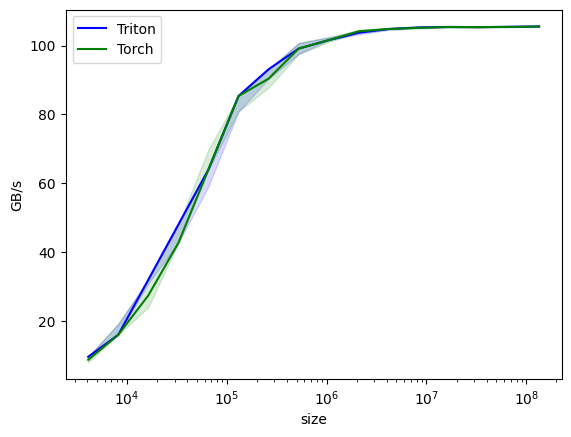

vector-add-performance:
           size      Triton       Torch
0        4096.0    9.600000    8.727273
1        8192.0   15.999999   15.999999
2       16384.0   31.999999   27.428571
3       32768.0   48.000000   42.666665
4       65536.0   63.999998   63.999998
5      131072.0   85.333330   85.333330
6      262144.0   93.090908   90.352940
7      524288.0   99.096776   99.096776
8     1048576.0  101.553721  101.553721
9     2097152.0  103.696202  104.135590
10    4194304.0  104.801708  104.801708
11    8388608.0  105.250534  105.137966
12   16777216.0  105.391584  105.364225
13   33554432.0  105.335119  105.335119
14   67108864.0  105.433969  105.391584
15  134217728.0  105.533012  105.511775


In [82]:
benchmark.run(print_data=True, show_plots=True)